In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import context

In [3]:
from IPython.display import display

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [5]:
import os
import pickle
import numpy as np
from datetime import datetime

In [6]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, ToPILImage, Lambda, Compose
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

In [7]:
from bestiary.criteria.autoencoder import AutoEncoderLoss

In [8]:
from bestiary.nets.wgan import WassersteinGenerativeAdversarialNet

In [9]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint, ProgressBar, Callback
from skorch.callbacks import TensorBoard, BatchScoring, EpochScoring, PassthroughScoring, LRScheduler
from skorch.dataset import CVSplit

In [10]:
import matplotlib.pyplot as plt

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from tensorboardX import SummaryWriter

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [13]:
from sklearn.datasets import fetch_openml

In [14]:
from skopt import BayesSearchCV

In [15]:
from scipy.stats import loguniform, randint

# Data

In [16]:
mnist = MNIST('data', download=True, transform=Compose([ToTensor(), Lambda(lambda x: x.reshape(28, 28))]))

In [17]:
class Painter(nn.Module):
    
    def __init__(self, hidden_dim=32, n_layers=3):
        
        super(Painter, self).__init__()
        
        self.module = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Tanh(),
            *[
                nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.Tanh(),
                )
                for _ in range(n_layers)
            ],
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.module(x)

In [76]:
def initialisation(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.001)

In [77]:
module = Painter(20, 10)

In [78]:
module.apply(initialisation)

Painter(
  (module): Sequential(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Tanh()
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (5): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (6): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (7): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (8): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (9): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (10): Sequential(
      (0): Lin

In [79]:
pixels = 280
z = torch.randn((1, 1))

grid = torch.stack((
    torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
    torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
), dim=-1).view(-1, 2)

#grid = torch.cat((grid, (grid - .5).norm(dim=1, keepdim=True), torch.randn(1, 1).repeat(grid.shape[0], 1)), dim=1)
grid = torch.cat((grid, (grid - .5).norm(dim=1, keepdim=True)), dim=1)

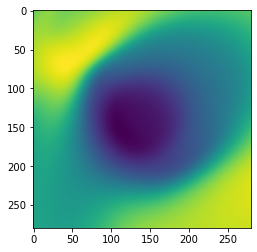

In [80]:
z = torch.randn((1, 1))
input_ = torch.cat((grid, z.repeat(len(grid), 1)), dim=1)

plt.imshow(module(input_[:, :-1]).view(pixels, pixels).detach())

In [81]:
def create_dataset(image):
    h, w = image.shape
    
    X = torch.stack((
        torch.linspace(0, 1, h).view(-1, 1).repeat(1, w),
        torch.linspace(0, 1, w).view(1, -1).repeat(h, 1),
    ), dim=-1).view(-1, 2)
    y = image.view(-1, 1)
    
    X = torch.cat((X, (X - .5).norm(dim=1, keepdim=True)), dim=1)
    
    return X, y

In [82]:
def predict_image(net, pixels=28):

    grid = torch.stack((
        torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
        torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
    ), dim=-1)

    grid = torch.cat((grid, (grid - .5).norm(dim=2, keepdim=True)), dim=2)
    
    return net.predict(grid).reshape(pixels, pixels)

In [39]:
def show(net, pixels):
    image = predict_image(painter, pixels)
    return to_pil_image(torch.tensor(image).reshape(1, pixels, pixels))

In [40]:
x, _ = mnist[np.random.randint(len(mnist))]

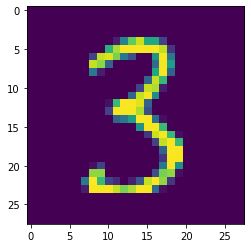

In [41]:
plt.imshow(x)

In [42]:
X, y = create_dataset(x)

In [108]:
painter = NeuralNetRegressor(
    module=Painter,
    module__hidden_dim=30,
    module__n_layers=5,
    batch_size=16,
    iterator_train__shuffle=True,
    train_split=CVSplit(20),
    optimizer=torch.optim.Adam,
    lr=1e-3,
    max_epochs=50,
    verbose=1,
    warm_start=True,
    callbacks=[
      ('scheduler', LRScheduler(monitor='train_loss', patience=2, policy=torch.optim.lr_scheduler.ReduceLROnPlateau, factor=.5)),
    ]
)

Re-initializing module because the following parameters were re-set: hidden_dim, n_layers.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1200        0.0040  0.0714
      2        0.0974        0.0025  0.0688
      3        0.0923        0.0015  0.0647
      4        0.0882        0.0026  0.0647
      5        0.0809        0.0011  0.0644
      6        0.0754        0.0009  0.0701
      7        0.0802        0.0012  0.0652
      8        0.0712        0.0010  0.0689
      9        0.0676        0.0007  0.0685
     10        0.0619        0.0006  0.0647
     11        0.0641        0.0005  0.0667
     12        0.0635        0.0006  0.0638
     13        0.0645        0.0003  0.0631
     14        0.0593        0.0002  0.0698
     15        0.0528        0.0003  0.0751
     16        0.0499        0.0002  0.0664
     17        0.0506        0.0002  0.0625
     18        0.0494        0.0001  0.0709
  

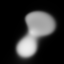

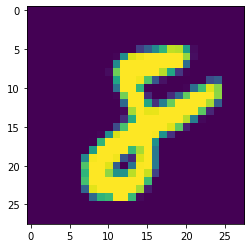

In [118]:
x, _ = mnist[np.random.randint(len(mnist))]
plt.imshow(x)
X, y = create_dataset(x)

painter.initialize()
painter.module_.apply(initialisation)

painter.fit(X, y)
show(painter, 64)

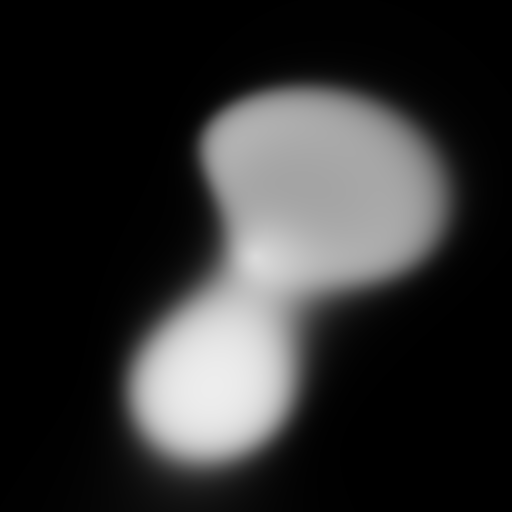

In [119]:
show(painter, 512)

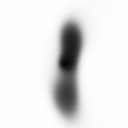

In [117]:
n = 128
image = predict_image(painter, n)
to_pil_image(1 - torch.tensor(image).reshape(1, n, n))

In [402]:
def predict_image(net, pixels=28):

    grid = torch.stack((
        torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
        torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
    ), dim=-1).view(-1, 2)

    grid = torch.cat((grid, (grid - .5).norm(dim=1, keepdim=True)), dim=1)
    
    return net.predict(grid).reshape(pixels, pixels)

In [407]:
def show(net, pixels):
    image = predict_image(painter, pixels)
    return to_pil_image(1 - torch.tensor(image).reshape(1, pixels, pixels))

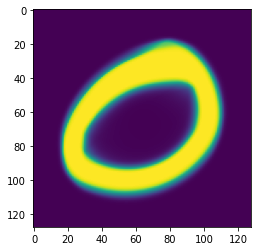

In [395]:
pixels = 128

grid = torch.stack((
    torch.linspace(0, 1, pixels).view(-1, 1).repeat(1, pixels),
    torch.linspace(0, 1, pixels).view(1, -1).repeat(pixels, 1),
), dim=-1).view(-1, 2)

grid = torch.cat((grid, (grid - .5).norm(dim=1, keepdim=True)), dim=1)

image = painter.predict(grid).reshape(pixels, pixels)

plt.imshow(image)

In [360]:
image

array([[3.5578119e-38, 4.0667772e-38, 4.6485885e-38, ..., 1.1844918e-18,
        1.0783974e-18, 9.8179835e-19],
       [3.8281739e-38, 4.3758496e-38, 5.0018777e-38, ..., 1.2490888e-18,
        1.1371999e-18, 1.0353375e-18],
       [4.1207785e-38, 4.7102434e-38, 5.3839473e-38, ..., 1.3171988e-18,
        1.1992180e-18, 1.0918003e-18],
       ...,
       [5.9638118e-29, 7.0746960e-29, 8.3925039e-29, ..., 4.0062027e-23,
        3.6958717e-23, 3.4095143e-23],
       [5.5697094e-29, 6.6071326e-29, 7.8378482e-29, ..., 3.7228839e-23,
        3.4344997e-23, 3.1683936e-23],
       [5.2016106e-29, 6.1705176e-29, 7.3199048e-29, ..., 3.4595754e-23,
        3.1916116e-23, 2.9443473e-23]], dtype=float32)

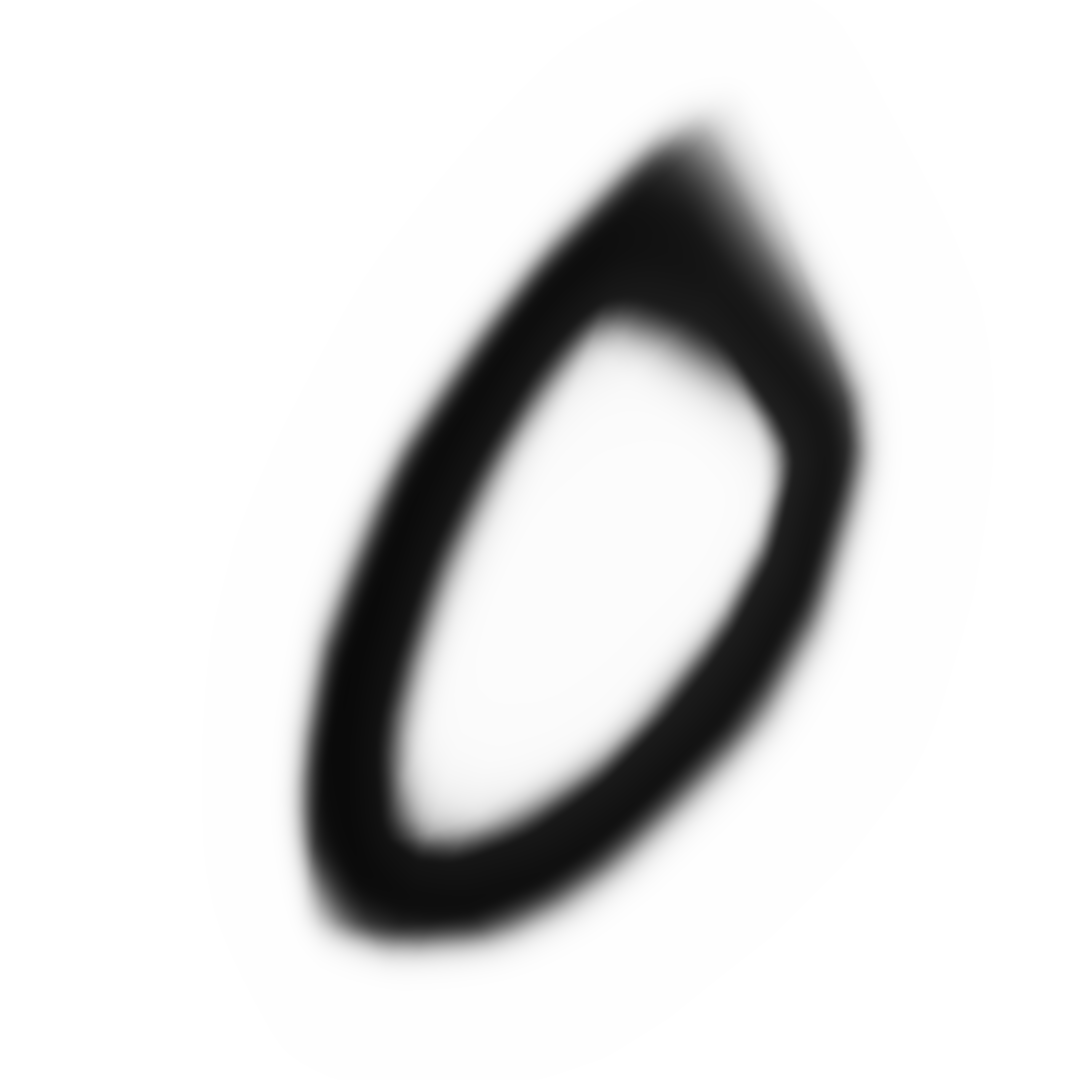

In [362]:
to_pil_image(1 - torch.tensor(image).reshape(1, 1080, 1080))